In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

In [2]:
from matplotlib import rc
rc('font', size=14)

In [3]:
from numpy import loadtxt, arange, log, delete, array, ones, concatenate
from numpy.linalg import lstsq
from scipy.stats import f
from scipy.stats.mstats import normaltest
from pandas.stats.moments import ewma
from pandas import Series

In [4]:
from common import *

In [5]:
MAX_POW = 2
CRITICAL_F = 4.2

In [6]:
dataset = loadtxt('data.csv', skiprows=1, delimiter=',')
t = arange(dataset.shape[0])
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()
XS = [TimeSeries(x) for x in xs]

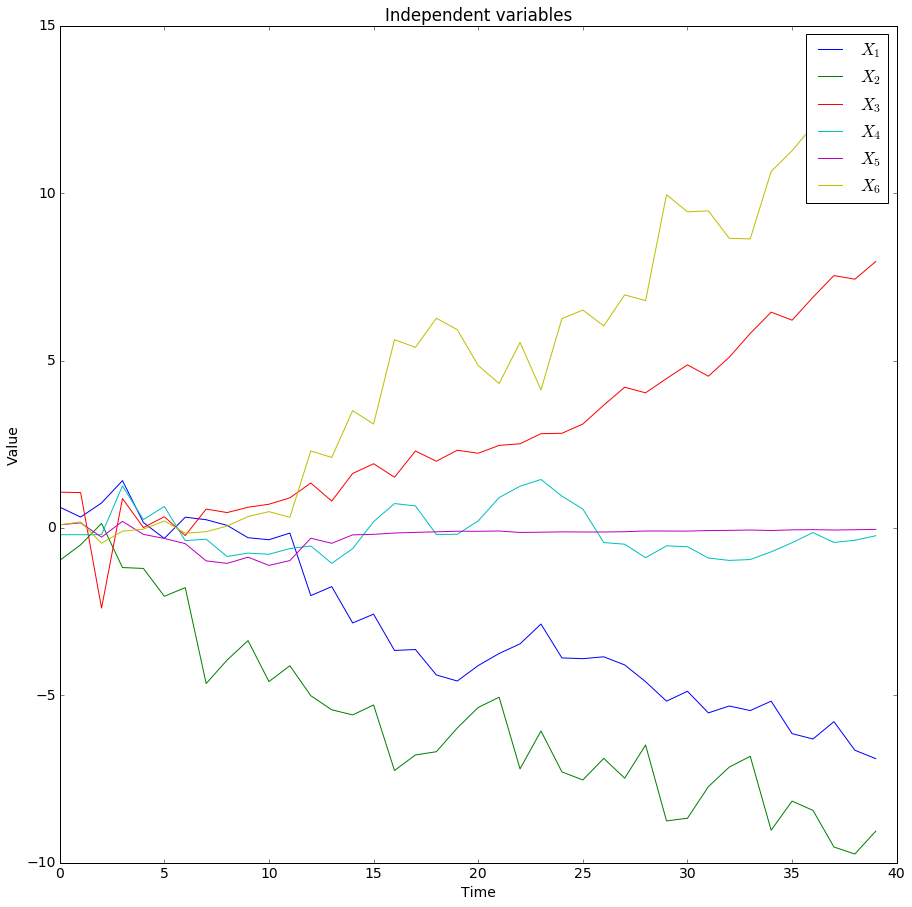

In [7]:
for i, x in enumerate(XS):
    plt.plot(t, x.data, label='$X_%d$'%(i+1))

plt.title('Independent variables')
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()

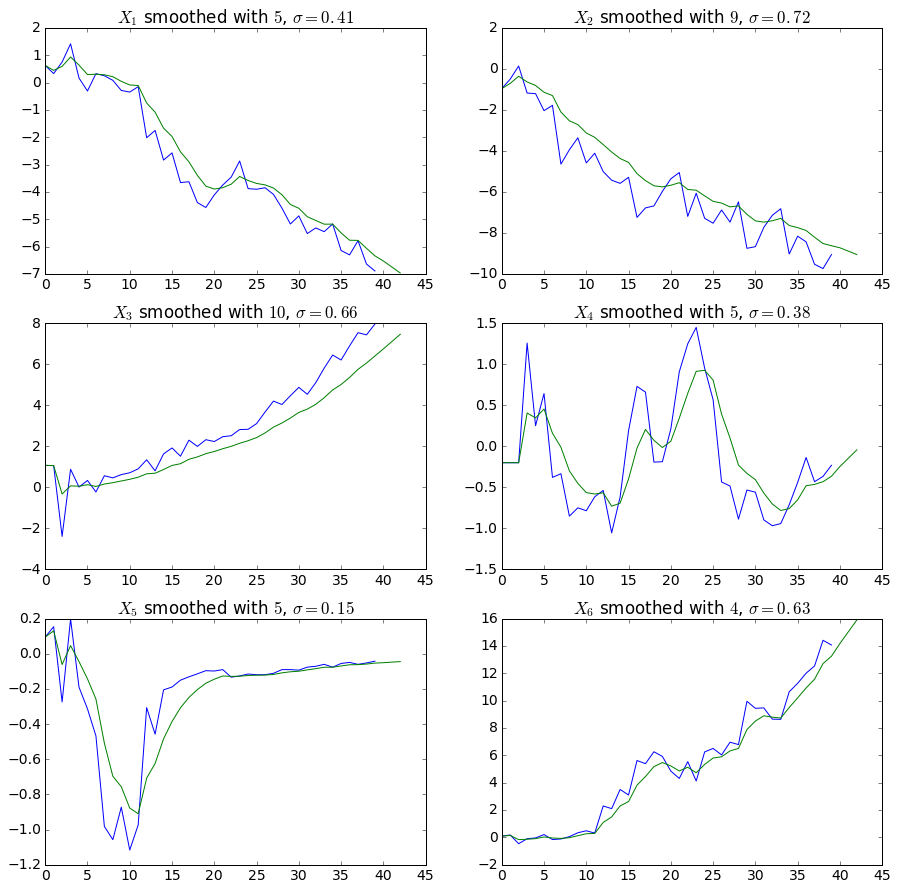

In [8]:
for i, x in enumerate(XS):
    i += 1
    plt.subplot(320 + i)
    plt.title(r'$X_{%d}$ smoothed with $%d$, $\sigma=%2.2f$'%(i, x.span, x.trend_errors.std()))
    plt.plot(x.data)
    plt.plot(x.trend_forecasted)
plt.show()

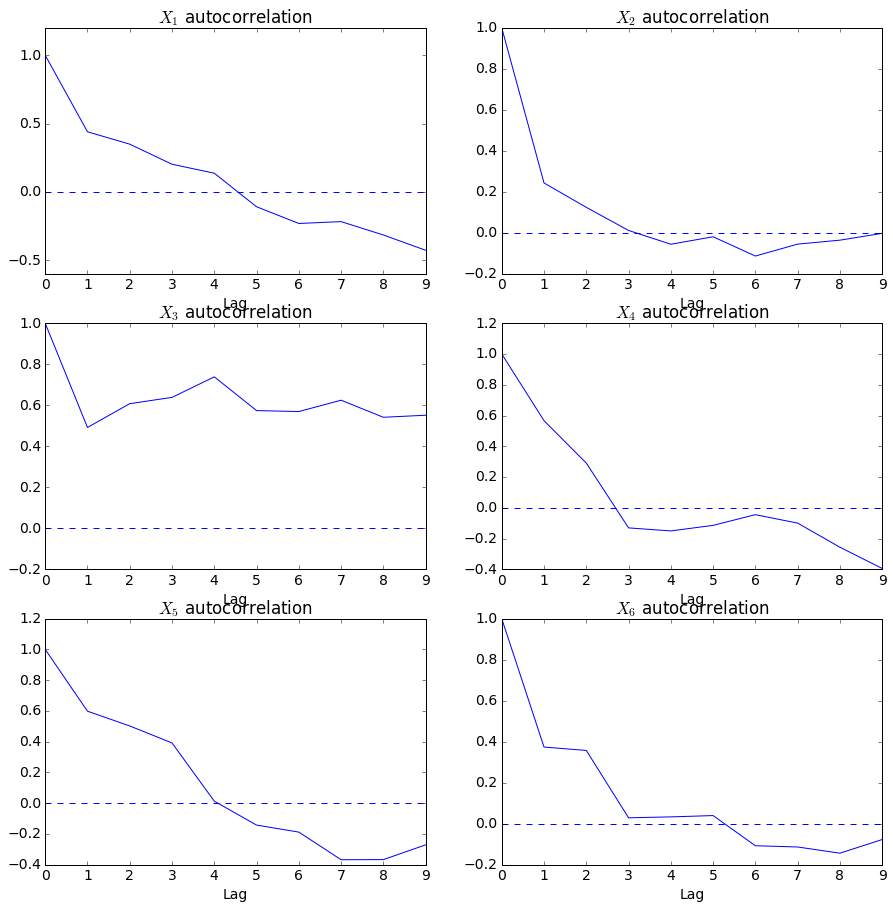

In [9]:
for i, x in enumerate(XS):
    i += 1
    plt.subplot(320 + i)
    plt.title(r'$X_{%d}$ autocorrelation'%i)
    plt.plot(x.autocorrelation)
    plt.axhline(linestyle='--')
    plt.xlabel('Lag')
plt.show()

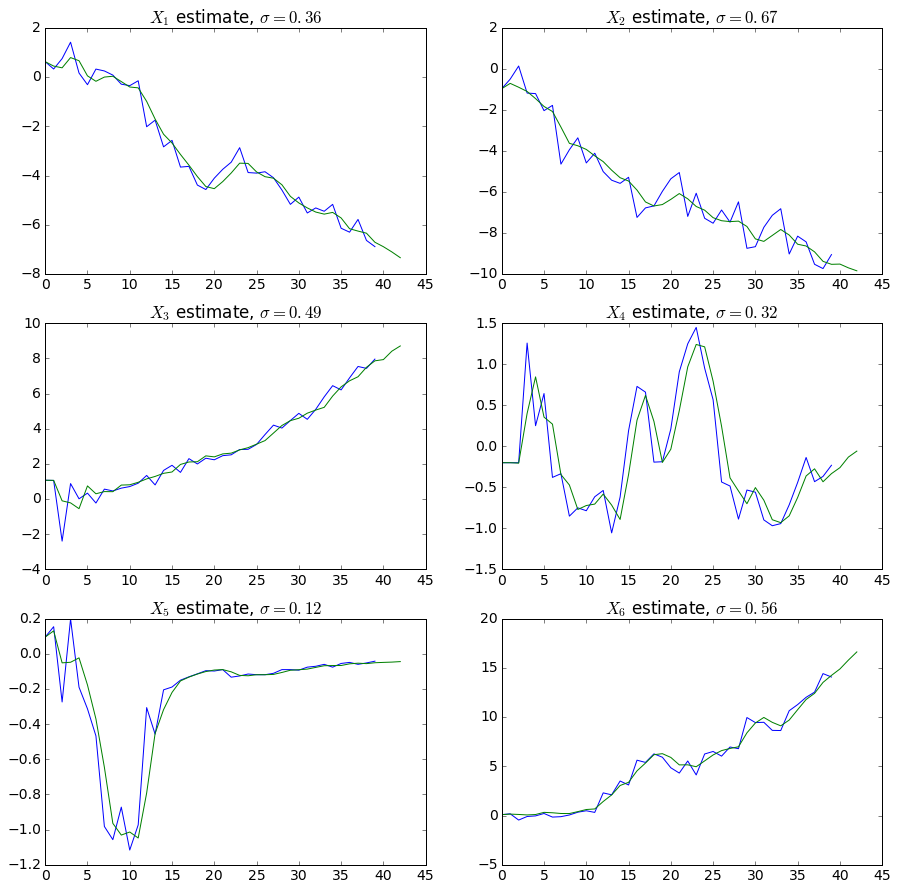

In [10]:
for i, x in enumerate(XS):
    i += 1
    plt.subplot(320 + i)
    plt.title(r'$X_{%d}$ estimate, $\sigma=%2.2f$'%(i, x.estimate_errors.std()))
    plt.plot(x.data)
    plt.plot(x.data_forecasted)
plt.show()

In [11]:
accum = [xs]
last = xs
names = []
for i in range(xs.shape[0]):
    names.append('x%d'%(i+1))
for i in range(MAX_POW-1):
    last = [last[i]*xs[i:] for i in range(xs.shape[0])]
    for i in range(xs.shape[0]):
        for j in range(len(last[i])):
            names.append('%s * %s'%(names[j], names[i]))
    accum += last
sequences = concatenate(accum)

In [12]:
new_sequences = sequences.copy()
coefficients = [y.mean()]
regressors = [ones(sequences[0].size)]
all_coefficients = [coefficients[0]]
all_regressors = [regressors[0]]
print('Step', 0, 'best is', y.mean())
for i in range(min(sequences.shape[0], y.size)):
    regressors, coefficients, new_sequences, F, best = get_coeffs(y, regressors, coefficients, new_sequences)
    all_coefficients.append(coefficients)
    all_regressors.append(regressors[-1])
    print('Step', i + 1, 'best is', best, names[best])
    if F < CRITICAL_F:
        print('Coefficients', coefficients)
        break
else:
    print('Best solution not found')

Step 0 best is -95.740525
Step 1 best is 2 x3
Step 2 best is 18 x2 * x3
Step 3 best is 22 x2 * x4
Step 4 best is 19 x3 * x3
Coefficients [ -17.92984215  -16.50578193  197.28851566  108.35006171   23.65418179]
